In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [106]:
#inspect measurement columns
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [107]:
#inspect station columns
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [108]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the last date in the data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23').\
        order_by(Measurement.date).all()
precip_query


# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip_query, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
precip_df.sort_values(by=['date'])
precip_df.set_index('date', inplace=True)
precip_df.head()   

('2017-08-23',)
2016-08-23


precipitation
date                     
2016-08-23           0.00
2016-08-23           0.15
2016-08-23           0.05
2016-08-23            NaN
2016-08-23           0.02

Text(0.5, 1.0, 'Precipitation in Hawaii from 8-23-2016 to 8-23-2017')

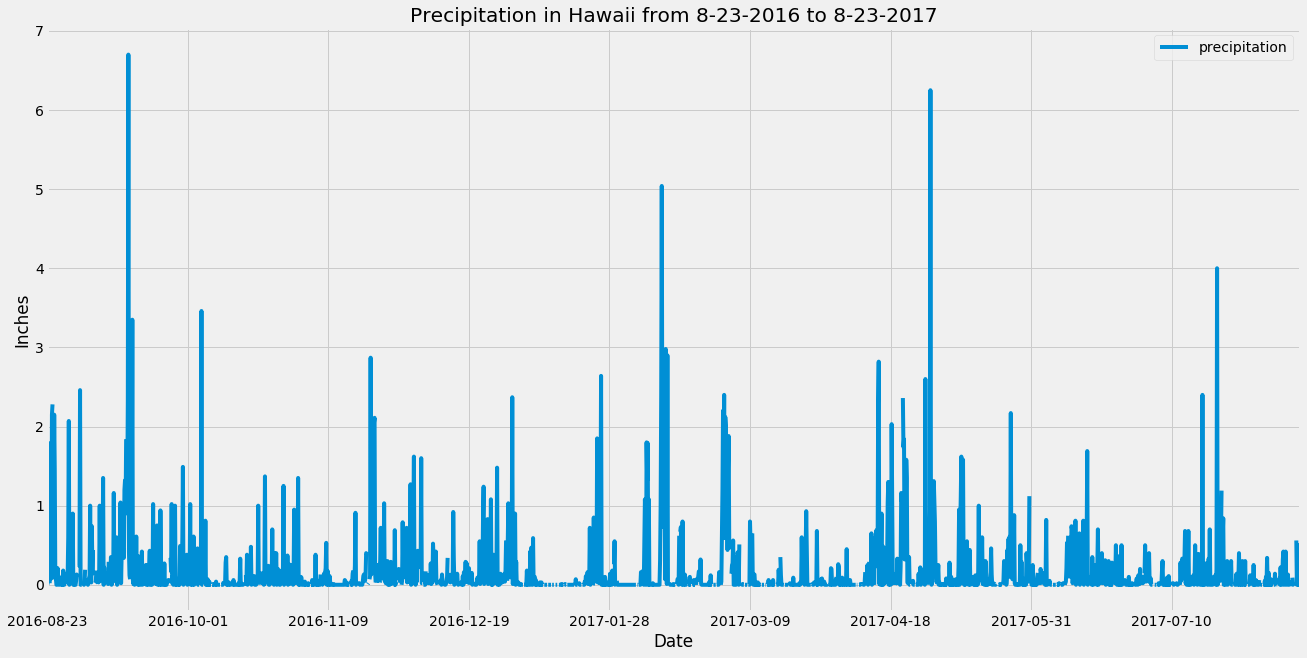

In [109]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(figsize = (20,10))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation in Hawaii from 8-23-2016 to 8-23-2017")



In [110]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [111]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).distinct().count()
print(station_count)

9


In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station)).\
                   group_by(Measurement.station).\
                   order_by(func.count(Measurement.station).desc()).all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [125]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = 'USC00519281'
temp_calcs= session.query(func.min(Measurement.tobs),\
            func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active).all()

print(f"The most active station is: {most_active}")
print(f"Lowest Temperature: {temp_calcs[0][0]} Fahrenheit")
print(f"Highest Temperature: {temp_calcs[0][1]} Fahrenheit")
print(f"Average Temperature: {round(temp_calcs[0][2], 2)} Fahrenheit")


The most active station is: USC00519281
Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [114]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
tobs_query = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_query, columns=["Temp. Observations"])
tobs_df


Temp. Observations
0                  77.0
1                  77.0
2                  80.0
3                  80.0
4                  75.0
..                  ...
347                77.0
348                77.0
349                76.0
350                76.0
351                79.0

[352 rows x 1 columns]

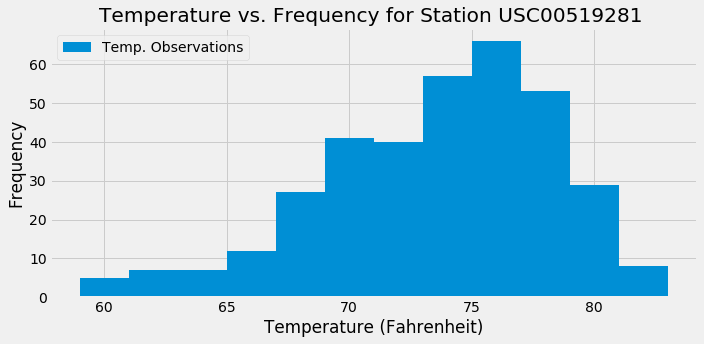

In [115]:
#plot the results as a histogram
tobs_df.plot.hist(bins=12, title="Temperature vs. Frequency for Station USC00519281 ", figsize=(10,5))
plt.xlabel("Temperature (Fahrenheit)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [117]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [118]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [119]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [120]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [121]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [122]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [123]:
# Plot the daily normals as an area plot with `stacked=False`
